# Recommending Films for Box Office Success!

![image](https://vip-go.premiumbeat.com/wp-content/uploads/2022/02/vr_2.jpg)

*Image by DOP Eben Bolter on the LED volume stage at Rebellion Film Studios in Oxford, UK.*

## Background

### Loading Tools and Data

Import our data science tools.

In [1]:
import itertools
import numpy as np
import pandas as pd 
from numbers import Number
import sqlite3
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

In [2]:
df_movie_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
df_movie_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t')
df_movie_reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', encoding='latin1')
df_tmdb_movies = pd.read_csv('zippedData/tmdb.movies.csv.gz')
df_movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

In [3]:
zip_path = 'zippedData/im.db.zip'
extract_path = 'zippedData/'

with zipfile.ZipFile(zip_path,'r') as zip_ref:
    zip_ref.extractall(extract_path)

db_path = os.path.join(extract_path, 'im.db')

conn = sqlite3.connect(db_path)
pd.read_sql("""
    SELECT *
    FROM sqlite_master
    WHERE type = 'table';
""",conn)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [4]:
df_movie_basics = pd.read_sql("""
    SELECT *
    FROM movie_basics;
""",conn)

df_directors = pd.read_sql("""
    SELECT *
    FROM directors;
""",conn)

df_known_for = pd.read_sql("""
    SELECT *
    FROM known_for;
""",conn)

df_movie_akas = pd.read_sql("""
    SELECT *
    FROM movie_akas;
""",conn)

df_movie_ratings = pd.read_sql("""
    SELECT *
    FROM movie_ratings;
""",conn)

df_persons = pd.read_sql("""
    SELECT *
    FROM persons;
""",conn)

df_principals = pd.read_sql("""
    SELECT *
    FROM principals;
""",conn)

df_writers = pd.read_sql("""
    SELECT *
    FROM writers;
""",conn)

## Exploratory Data Analysis

### Step 1. Data Understanding
- Dataframe `shape`
- `head` and `tail`
- `info`
- `describe`

In [5]:
df_movie_gross.shape

(3387, 5)

In [6]:
df_movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [7]:
df_movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [8]:
df_movie_gross.describe()

,domestic_gross,year
count,3.359000e+03,3387.000000
mean,2.874585e+07,2013.958075
std,6.698250e+07,2.478141
min,1.000000e+02,2010.000000
25%,1.200000e+05,2012.000000
50%,1.400000e+06,2014.000000
75%,2.790000e+07,2016.000000
max,9.367000e+08,2018.000000


### Step 2. Data Preparation
- Dropping irrelevant columns and rows
- Identifying duplicated columns
- Renaming columns
- Feature creation

In [9]:
df_movie_gross.columns

Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')

In [10]:
df_movie_gross = df_movie_gross[['title', #'studio', 
                                 'domestic_gross', 'foreign_gross', 'year']].copy()
df_movie_gross

,title,domestic_gross,foreign_gross,year
0,Toy Story 3,415000000.0,652000000,2010
1,Alice in Wonderland (2010),334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,296000000.0,664300000,2010
3,Inception,292600000.0,535700000,2010
4,Shrek Forever After,238700000.0,513900000,2010
...,...,...,...,...
3382,The Quake,6200.0,NaN,2018
3383,Edward II (2018 re-release),4800.0,NaN,2018
3384,El Pacto,2500.0,NaN,2018
3385,The Swan,2400.0,NaN,2018


In [11]:
df_movie_gross.info()
df_movie_gross.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   domestic_gross  3359 non-null   float64
 2   foreign_gross   2037 non-null   object 
 3   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 106.0+ KB


title                0
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

In [12]:
df_movie_gross.loc[df_movie_gross.duplicated(subset='title')]

,title,domestic_gross,foreign_gross,year
3045,Bluebeard,43100.0,NaN,2017


In [13]:
df_movie_gross[df_movie_gross.title == 'Bluebeard']

,title,domestic_gross,foreign_gross,year
317,Bluebeard,33500.0,5200,2010
3045,Bluebeard,43100.0,NaN,2017


In [14]:
df_movie_gross.isna().sum()

title                0
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

In [15]:
df_movie_gross[df_movie_gross.isnull().any(axis=1)]

,title,domestic_gross,foreign_gross,year
222,Flipped,1800000.0,NaN,2010
230,It's a Wonderful Afterlife,NaN,1300000,2010
254,The Polar Express (IMAX re-issue 2010),673000.0,NaN,2010
267,Tiny Furniture,392000.0,NaN,2010
269,Grease (Sing-a-Long re-issue),366000.0,NaN,2010
...,...,...,...,...
3382,The Quake,6200.0,NaN,2018
3383,Edward II (2018 re-release),4800.0,NaN,2018
3384,El Pacto,2500.0,NaN,2018
3385,The Swan,2400.0,NaN,2018


In [16]:
# Drop null values
df_movie_gross.dropna()

,title,domestic_gross,foreign_gross,year
0,Toy Story 3,415000000.0,652000000,2010
1,Alice in Wonderland (2010),334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,296000000.0,664300000,2010
3,Inception,292600000.0,535700000,2010
4,Shrek Forever After,238700000.0,513900000,2010
...,...,...,...,...
3275,I Still See You,1400.0,1500000,2018
3286,The Catcher Was a Spy,725000.0,229000,2018
3309,Time Freak,10000.0,256000,2018
3342,Reign of Judges: Title of Liberty - Concept Short,93200.0,5200,2018


In [17]:
df_movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   domestic_gross  3359 non-null   float64
 2   foreign_gross   2037 non-null   object 
 3   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 106.0+ KB


In [18]:
df_movie_gross = df_movie_gross[['title', #'studio', 
                                 'domestic_gross', #'foreign_gross', 
                                 'year']].copy()
df_movie_gross

,title,domestic_gross,year
0,Toy Story 3,415000000.0,2010
1,Alice in Wonderland (2010),334200000.0,2010
2,Harry Potter and the Deathly Hallows Part 1,296000000.0,2010
3,Inception,292600000.0,2010
4,Shrek Forever After,238700000.0,2010
...,...,...,...
3382,The Quake,6200.0,2018
3383,Edward II (2018 re-release),4800.0,2018
3384,El Pacto,2500.0,2018
3385,The Swan,2400.0,2018


In [19]:
df_movie_gross = df_movie_gross.dropna().reset_index(drop=True)
df_movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3359 entries, 0 to 3358
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3359 non-null   object 
 1   domestic_gross  3359 non-null   float64
 2   year            3359 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 78.9+ KB


In [20]:
df_movie_gross

,title,domestic_gross,year
0,Toy Story 3,415000000.0,2010
1,Alice in Wonderland (2010),334200000.0,2010
2,Harry Potter and the Deathly Hallows Part 1,296000000.0,2010
3,Inception,292600000.0,2010
4,Shrek Forever After,238700000.0,2010
...,...,...,...
3354,The Quake,6200.0,2018
3355,Edward II (2018 re-release),4800.0,2018
3356,El Pacto,2500.0,2018
3357,The Swan,2400.0,2018


### Step 3. Feature Understanding
- Plotting Feature Distributions
    - Histogram
    - KDE
    - Boxplot

#### Bar Graph of Movies' Gross Revenues

In [21]:
df_movie_gross.sort_values(by='domestic_gross', ascending=False).head(10)

,title,domestic_gross,year
1849,Star Wars: The Force Awakens,936700000.0,2015
3052,Black Panther,700100000.0,2018
3051,Avengers: Infinity War,678800000.0,2018
1850,Jurassic World,652300000.0,2015
720,Marvel's The Avengers,623400000.0,2012
2731,Star Wars: The Last Jedi,620200000.0,2017
3054,Incredibles 2,608600000.0,2018
2299,Rogue One: A Star Wars Story,532200000.0,2016
2732,Beauty and the Beast (2017),504000000.0,2017
2300,Finding Dory,486300000.0,2016


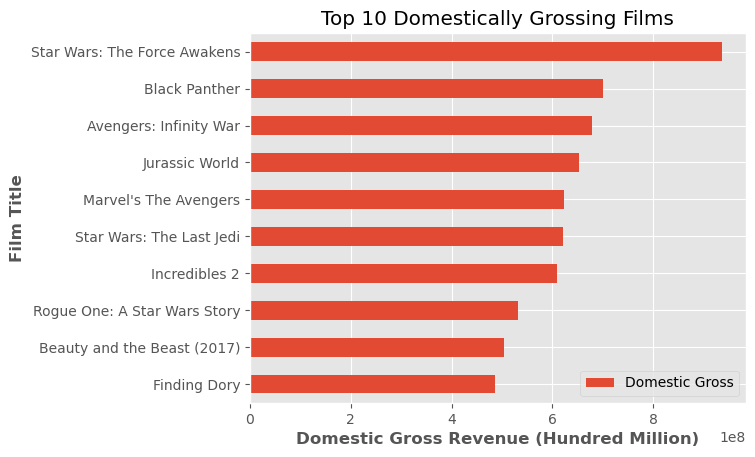

In [22]:
ax = df_movie_gross.sort_values(by='domestic_gross', ascending=False).head(10) \
    .sort_values(by='domestic_gross', ascending=True) \
    .plot(kind='barh', x='title', y='domestic_gross', label='Domestic Gross')
ax.set_title('Top 10 Domestically Grossing Films')
ax.set_ylabel('Film Title', fontweight='bold')
ax.set_xlabel('Domestic Gross Revenue (Hundred Million)', fontweight='bold')
plt.show()

#### Histograms of Movies' Gross Revenues

In [23]:
def render_distribution_gross_revenue(ax, data=df_movie_gross, column='domestic_gross', boundary=200000000, direction='greater'):
    if direction == 'greater':
        sns.histplot(data=data[data[column] >= boundary][column], bins = 20, kde = True, ax=ax)
        ax.set_title('Frequency of Domestic Gross Revenue Amongst Various Titles')
        ax.set_xlabel(f'Film Domestic Gross Revenue Over ${boundary:,.0f}')
        ax.set_ylabel('Frequency')
    elif direction == 'lesser':
        sns.histplot(data=data[data[column] <= boundary][column], bins = 20, kde = True, ax=ax)
        ax.set_title('Frequency of Domestic Gross Revenue Amongst Various Titles')
        ax.set_xlabel(f'Film Domestic Gross Revenue Under ${boundary:,.0f}')
        ax.set_ylabel('Frequency')
    plt.tight_layout()
def render_kde_gross_revenue(ax, data=df_movie_gross, column='domestic_gross', boundary=200000000, direction='greater'):
    if direction == 'greater':
        sns.kdeplot(data=data[data[column] >= boundary][column], ax=ax)
        ax.set_title('Frequency of Domestic Gross Revenue Amongst Various Titles')
        ax.set_xlabel(f'Film Domestic Gross Revenue Over ${boundary:,.0f}')
        ax.set_ylabel('Frequency')
    elif direction == 'lesser':
        sns.kdeplot(data=data[data[column] <= boundary][column], ax=ax)
        ax.set_title('Frequency of Domestic Gross Revenue Amongst Various Titles')
        ax.set_xlabel(f'Film Domestic Gross Revenue Under ${boundary:,.0f}')
        ax.set_ylabel('Frequency')
    plt.tight_layout()

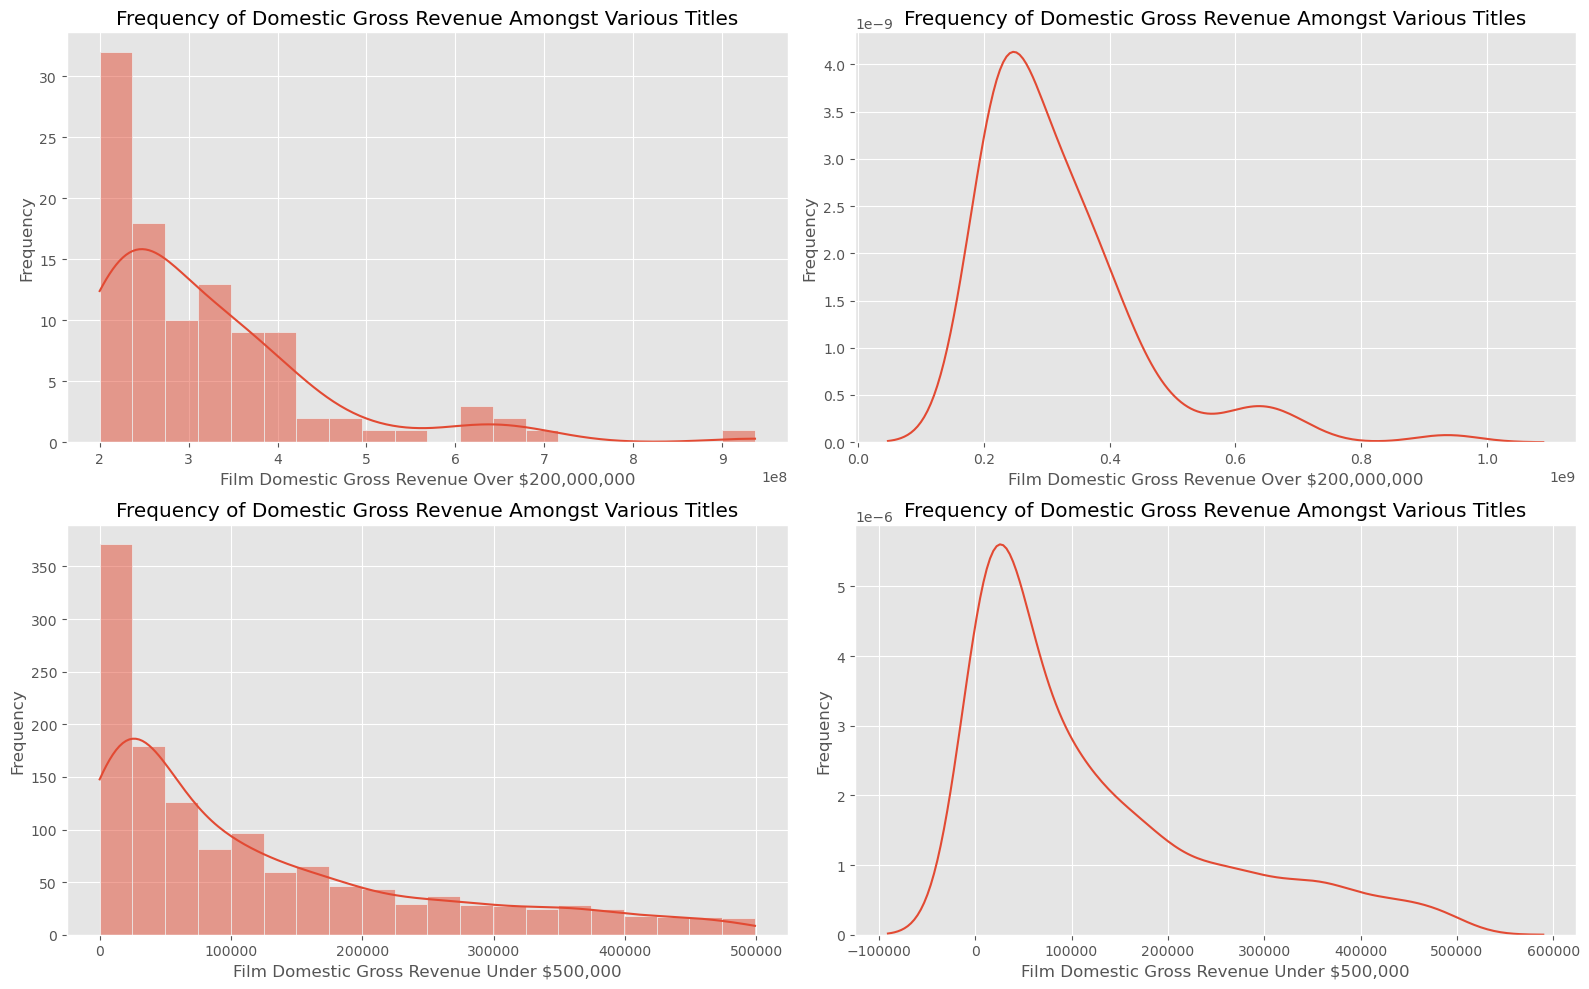

In [24]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(16,10))
render_distribution_gross_revenue(ax=ax1, boundary = 200000000, direction='greater')
render_kde_gross_revenue(ax=ax2, boundary = 200000000, direction='greater')
render_distribution_gross_revenue(ax=ax3, boundary=500000, direction='lesser')
render_kde_gross_revenue(ax=ax4, boundary=500000, direction='lesser')

#### Box Plot of Movies' Gross Revenues

In [25]:
def render_boxplot_gross_revenue(ax=ax, data=df_movie_gross, column='domestic_gross', boundary=200000000, direction='greater'):
    if direction == 'greater':
        sns.boxplot(x=data[data[column] >= boundary][column], ax=ax)
        ax.set_title('Frequency of Domestic Gross Revenue Amongst Various Titles')
        ax.set_xlabel(f'Film Domestic Gross Revenue Over ${boundary:,.0f}')
        ax.set_ylabel('Frequency')
    elif direction == 'lesser':
        sns.boxplot(x=data[data[column] <= boundary][column], ax=ax)
        ax.set_title('Frequency of Domestic Gross Revenue Amongst Various Titles')
        ax.set_xlabel(f'Film Domestic Gross Revenue Under ${boundary:,.0f}')
        ax.set_ylabel('Frequency')
    plt.tight_layout()

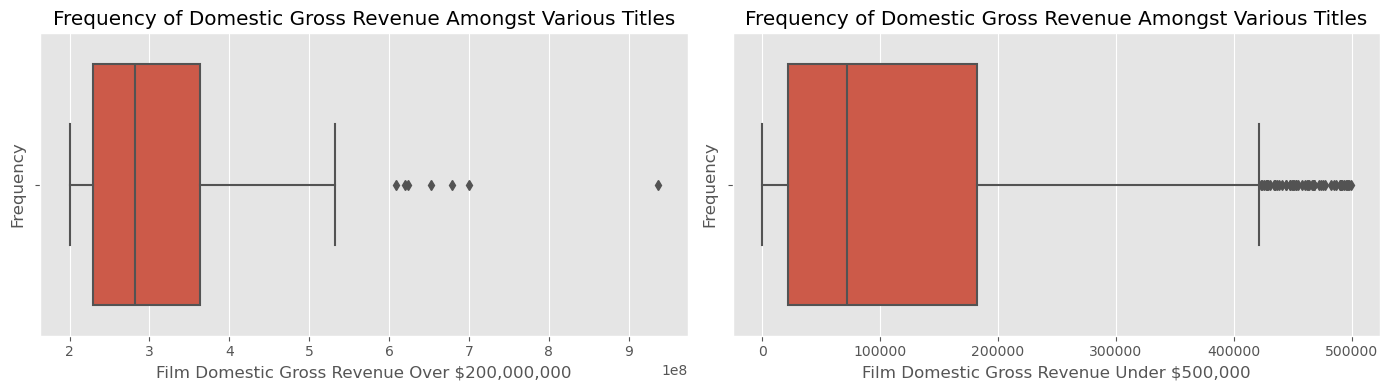

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
render_boxplot_gross_revenue(ax=ax1, boundary = 200000000, direction='greater')
render_boxplot_gross_revenue(ax=ax2, boundary = 500000, direction='lesser')

### Step 4. Feature Relationships
- Scatterplot
- Heatmap Correlation
- Pairplot
- Groupby Comparisons

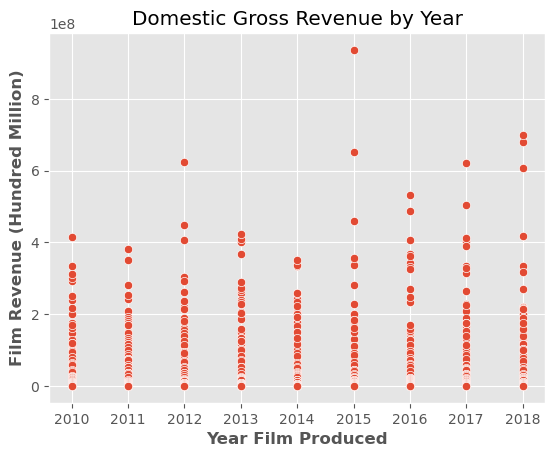

In [27]:
sns.scatterplot(data=df_movie_gross, x='year', y='domestic_gross')
plt.title('Domestic Gross Revenue by Year')
plt.xlabel('Year Film Produced', fontweight='bold')
plt.ylabel('Film Revenue (Hundred Million)', fontweight='bold')
plt.show()

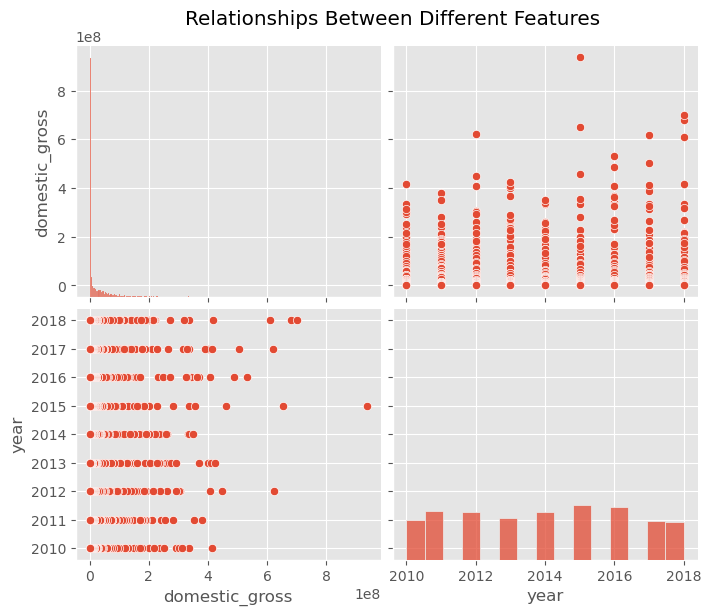

In [28]:
sns.pairplot(df_movie_gross, height=3, aspect=1.2)
plt.title('Relationships Between Different Features', y = 2.1, x=0)
plt.show()

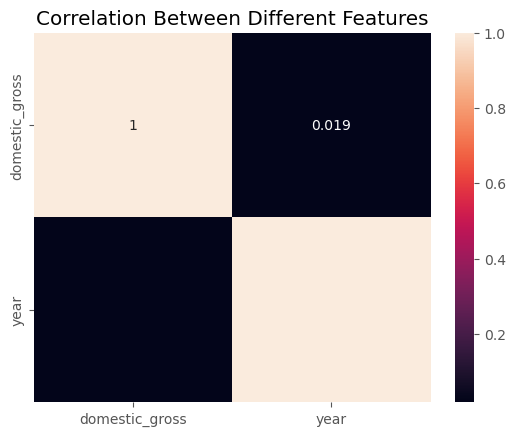

In [29]:
sns.heatmap(df_movie_gross[['domestic_gross','year']].corr(), annot=True)
plt.title('Correlation Between Different Features')
plt.show()

### Step 5. Ask Questions About The Data
- Try to ask and answer questions you have about the data using a plot or statistic.

In [35]:
df_movie_gross.head()

,title,domestic_gross,year
0,Toy Story 3,415000000.0,2010
1,Alice in Wonderland (2010),334200000.0,2010
2,Harry Potter and the Deathly Hallows Part 1,296000000.0,2010
3,Inception,292600000.0,2010
4,Shrek Forever After,238700000.0,2010


What is the total gross revenue by year?

In [83]:
pd.set_option('display.float_format', '${:,.0f}'.format)
total_gross = df_movie_gross.groupby('year')['domestic_gross'].agg(['sum','mean','count']).reset_index().copy()
total_gross = total_gross.rename(columns={'year':'Year', 'sum':'Total_Revenue', 'mean':'Avg_Revenue','count':'Title_Counts'})
total_gross

,Year,Total_Revenue,Avg_Revenue,Title_Counts
0,2010,"$10,156,926,399","$31,445,593",323
1,2011,"$10,064,158,200","$25,350,524",397
2,2012,"$10,876,605,997","$27,675,842",393
3,2013,"$10,792,329,897","$31,282,116",345
4,2014,"$10,337,738,499","$26,439,229",391
5,2015,"$11,051,405,394","$24,613,375",449
6,2016,"$11,253,653,097","$25,989,961",433
7,2017,"$10,933,266,198","$34,166,457",320
8,2018,"$11,091,209,899","$36,010,422",308


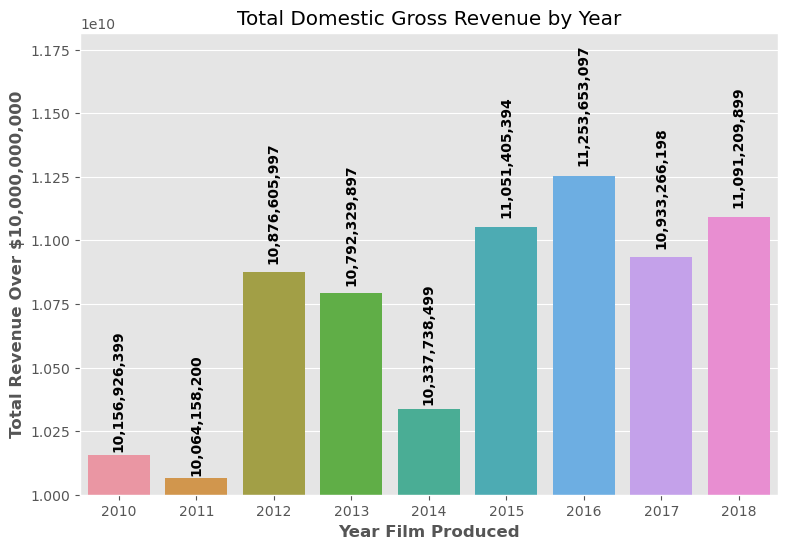

In [162]:
def add_labels(ax, values):
    for i, value in enumerate(values):
        ax.text(i, value * 1.025, f'{value:,.0f}', va='center', ha='center', color='black', rotation=90, fontweight='bold')

filtered_total_gross = total_gross[total_gross['Total_Revenue'] > 1000000000]
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.barplot(x='Year', y='Total_Revenue', data=filtered_total_gross)
add_labels(ax, filtered_total_gross['Total_Revenue'])
plt.title('Total Domestic Gross Revenue by Year')
plt.xlabel('Year Film Produced', fontweight='bold')
plt.ylabel('Total Revenue Over $10,000,000,000', fontweight='bold')
ax.set_ylim(10000000000, ax.get_ylim()[1])
plt.show()